# FastFarmInterace: an MPI-based Python-FastFarm interface to develop wind farm control policies 

**IMPORTANT** This notebook needs to be run on the WFCRL Interface kernel. Click on your kernel on the upper right of your notebook and select `WFCRL Interface`. You might need to refresh your page first.

![kernel_selection](img/chose_wfcrl_kernel.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from wfcrl.environments import data_cases as cases
from wfcrl.interface import FastFarmInterface

sns.set_theme(style="darkgrid")

We start by chosing the case to simulate. The library comes with a list of pre-existing farm layouts that can be found in `environments/data_cases.py`. Let us use the `Farm6Fastfarm`, which has 6 turbines organized in 2 rows.

In [2]:
config = cases.fastfarm_ablaincourt

In [3]:
config.num_turbines

7

In [4]:
config

Wind farm simulation on FastFarm: 7 turbines - 100 timesteps
max_iter: 100
num_turbines: 7
xcoords: [484.8, 797.1, 1038.8, 1377.6, 1716.9, 2057.3, 2400.0]
ycoords: [274.0, 251.0, 66.9, -22.7, -112.5, -195.3, -259.0]
dt: 3

We will control the yaw of all turbines, allowing to vary between -20 and 20°, with a maximum change between two iterations of 15°. We control the pitch between 0° and 45°, with a maximum step of 1°.

We can create the interface directly from the configuration:

In [5]:
num_iter = 100
ff_interface = FastFarmInterface.from_case(
    config,
    fast_farm_executable="simulators/fastfarm/bin/FAST.Farm_x64_OMP_2023.exe",
    #output_dir="path_to_output_dir"
)

Deltas: [2.10730392e-05 5.68972057e-04 9.90432840e-04 1.60155098e-03
 2.19159607e-03 2.80271421e-03 3.41383234e-03]
Exception has been raise. I put this print statement instead. Check with EB.
Exception: Some X0_High are not on an integer multiple of the high-res grid
Created FAST.Farm input file: simulators/fastfarm/inputs/FarmInputs/Case.fstf


To change the yaw, pitch or torque command, use the method `update_command(yaw, pitch, torque)`. Let's control the yaw and pitch:

In [6]:
ff_interface.init()
for i in range(num_iter):
    print("PYTHON: Iter ", i)
    yaw_command = np.zeros(ff_interface.num_turbines, dtype=np.double)
    pitch_command = np.zeros(ff_interface.num_turbines, dtype=np.double)
    if i > 20:
        yaw_command[0] = 30
        pitch_command[0] = 1
    ff_interface.update_command(yaw=yaw_command, pitch=pitch_command)
    print(f"Iter {i} - Sent command YAW {ff_interface.get_yaw_command()} - "
          f" PITCH {ff_interface.get_pitch_command()}"
          f" TORQUE {ff_interface.get_torque_command()}\n"
          f" Received Power: {ff_interface.last_powers().flatten()}"
          f" Wind : {ff_interface.last_wind().flatten()}\n"
    )

Spawning process simulators/fastfarm/bin/FAST.Farm_x64_OMP_2023.exe simulators/fastfarm/inputs/FarmInputs/Case.fstf
Interface: will receive 12 measures at every iteration
PYTHON: Iter  0
Iter 0 - Sent command YAW [0. 0. 0. 0. 0. 0. 0.] -  PITCH [0. 0. 0. 0. 0. 0. 0.] TORQUE None
 Received Power: [1599823.    1727455.875 1717034.    1486681.125 1738753.75  1681280.5
 1792345.5  ] Wind : [  8.92947006 273.77020264]

PYTHON: Iter  1
Iter 1 - Sent command YAW [0. 0. 0. 0. 0. 0. 0.] -  PITCH [0. 0. 0. 0. 0. 0. 0.] TORQUE None
 Received Power: [1647763.25  1866368.875 1843241.    1453648.5   1874914.5   1778609.125
 2001551.   ] Wind : [  8.92947006 273.77020264]

PYTHON: Iter  2
Iter 2 - Sent command YAW [0. 0. 0. 0. 0. 0. 0.] -  PITCH [0. 0. 0. 0. 0. 0. 0.] TORQUE None
 Received Power: [1682481.375 1942895.875 1921181.25  1475022.    1973378.5   1843918.625
 2107356.75 ] Wind : [  9.45887661 278.42581177]

PYTHON: Iter  3
Iter 3 - Sent command YAW [0. 0. 0. 0. 0. 0. 0.] -  PITCH [0. 0. 0. 

## Custom case creation

You can also use the WFCRL utils function `create_ff_case`  to create a case without using the interface. `create_ff_case` takes a dictionary with the simulation's configuration, which can be generated automatically from a `FastFarmCase`.

In [4]:
from wfcrl.simul_utils import create_ff_case
from wfcrl.environments import FastFarmCase

In [5]:
config = FastFarmCase(
    num_turbines=6,
    xcoords=[0.0, 504.0, 1008.0, 0.0, 504.0, 1008.0],
    ycoords=[-252, -252, -252, 252, 252, 252],
    dt=3,
    t_init=100,
)

In [6]:
config.dict()

{'max_iter': 100,
 'num_turbines': 6,
 'xcoords': [0.0, 504.0, 1008.0, 0.0, 504.0, 1008.0],
 'ycoords': [-252, -252, -252, 252, 252, 252],
 'dt': 3}

In [9]:
fstf_file = create_ff_case(config.dict(), output_dir="examples")

Deltas: [2.10730392e-05 9.06140684e-04 1.81228137e-03 2.10730392e-05
 9.06140684e-04 1.81228137e-03]
Exception has been raise. I put this print statement instead. Check with EB.
Exception: Some X0_High are not on an integer multiple of the high-res grid
Created FAST.Farm input file: examples/FarmInputs/Case.fstf


And start a simulation directly from a configuration file.

In [10]:
ff_interface = FastFarmInterface.from_file(fstf_file="examples/FarmInputs/Case.fstf")

Simulation will be started from fstf file examples/FarmInputs/Case.fstf
Creating new DLLs for simulation examples/FarmInputs/Case.fstf


In [13]:
ff_interface.init()
raw_measures = []
avg_wind = []
avg_powers = []
for i in range(ff_interface.max_iter):
    print("PYTHON: Iter ", i)
    yaw_command = np.zeros(ff_interface.num_turbines, dtype=np.double)
    pitch_command = np.zeros(ff_interface.num_turbines, dtype=np.double)
    if i > 20:
        yaw_command[0] = 30
        pitch_command[0] = 1
    ff_interface.update_command(yaw=yaw_command, pitch=pitch_command)
    print(f"Iter {i} - Sent command YAW {ff_interface.get_yaw_command()} - "
          f" PITCH {ff_interface.get_pitch_command()}"
          f" TORQUE {ff_interface.get_torque_command()}\n"
          f" Received Power: {ff_interface.last_powers().flatten()}"
          f" Wind : {ff_interface.last_wind().flatten()}\n"
    )
    raw_measures.append(ff_interface.get_all_measures())
    avg_powers.append(ff_interface.avg_powers(window=30))
    avg_wind.append(ff_interface.avg_wind(window=30))

Spawning process simulators/fastfarm/bin/FAST.Farm_x64_OMP_2023.exe examples/FarmInputs/Case.fstf
Interface: will receive 12 measures at every iteration
PYTHON: Iter  0
Iter 0 - Sent command YAW [0. 0. 0. 0. 0. 0.] -  PITCH [0. 0. 0. 0. 0. 0.] TORQUE None
 Received Power: [1681373.75  1745663.    1569152.875 1544478.125 1597603.25  1651373.75 ] Wind : [  8.74695969 276.0602417 ]

PYTHON: Iter  1
Iter 1 - Sent command YAW [0. 0. 0. 0. 0. 0.] -  PITCH [0. 0. 0. 0. 0. 0.] TORQUE None
 Received Power: [1769168.625 1899784.375 1608361.875 1558410.875 1653030.5   1711922.375] Wind : [  8.74695969 276.0602417 ]

PYTHON: Iter  2
Iter 2 - Sent command YAW [0. 0. 0. 0. 0. 0.] -  PITCH [0. 0. 0. 0. 0. 0.] TORQUE None
 Received Power: [1827499.    1999871.375 1653510.5   1518362.    1673014.25  1734390.5  ] Wind : [  8.62154484 269.13616943]

PYTHON: Iter  3
Iter 3 - Sent command YAW [0. 0. 0. 0. 0. 0.] -  PITCH [0. 0. 0. 0. 0. 0.] TORQUE None
 Received Power: [1828159.875 2038838.    1688261.875 

`FastFarmInterface` automatically processes and averages measurements for `power`, `wind_speed`, and `wind_direction`, which can be accesses via the `avg_powers(window)}` and `avg_wind(window)` methods, where `window` is the averaging window. The last method returns the wind measurements at the entrance of the farm, which includes the wind speed in m/s and the wind direction from the North in degrees. 

The history of power and wind can be accessed via the `last_powers()` and `last_wind()` methods.

Text(0.5, 1.0, 'Wind Direction from North (°)')

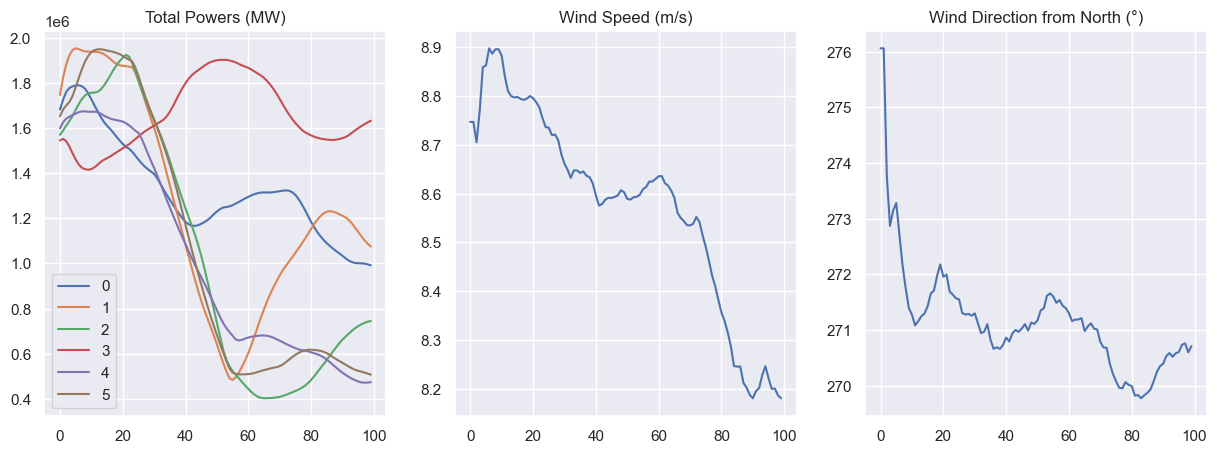

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
pd.DataFrame(avg_powers).plot(ax=ax[0])
wind_array = np.array(avg_wind)
ax[0].set_title("Total Powers (MW)")
sns.lineplot(wind_array[:, 0], ax=ax[1])
ax[1].set_title("Wind Speed (m/s)")
sns.lineplot(wind_array[:, 1]).plot(ax=ax[2])
ax[2].set_title("Wind Direction from North (°)")

Other raw measurements made during the simulation are however also available:

In [15]:
ff_interface.get_all_measures()

,wind_speed,power,wind_direction,yaw,pitch,torque,load_0,load_1,load_2,load_3,load_4,load_5
0,8.146130,1.042125e+06,-4.397914,30.002381,1.0,13080.217773,4036914.25,4504495.50,3787028.75,-9.898242e+05,-1.631010e+06,3.855734e+06
1,5.695601,8.155702e+05,-0.975462,0.000524,0.0,10585.519531,3822823.75,3392762.75,4565382.50,7.855961e+05,3.064809e+06,-2.873278e+06
2,4.464757,6.409996e+05,-16.755260,-0.000958,0.0,8551.193359,4158723.25,3410480.25,2739665.50,-2.660440e+06,3.003810e+05,3.164208e+06
3,8.440183,1.806509e+06,0.498361,0.004111,0.0,20442.771484,6251348.00,5223191.50,5694134.00,4.101690e+06,-2.346596e+06,1.127779e+05
4,4.872669,5.560325e+05,6.428565,0.003087,0.0,7523.439453,4076059.75,2919711.50,2929425.75,3.678232e+06,-4.006114e+05,-2.579616e+06
5,4.708821,4.253632e+05,-0.894381,-0.000094,0.0,5889.285156,2982687.00,2675800.50,3081227.50,1.035448e+06,-3.273495e+06,2.773415e+06


For 44 iterations, every turbine has returned 12 measures. Let's plot them:

In [16]:
df = pd.concat(raw_measures)
df["iter"] = np.arange(df.shape[0]) // ff_interface.num_turbines
df["turbine"] = df.index
df.head()

,wind_speed,power,wind_direction,yaw,pitch,torque,load_0,load_1,load_2,load_3,load_4,load_5,iter,turbine
0,8.479084,1681373.750,-0.070032,-0.001155,0.0,19560.169922,5379381.5,5836628.5,6021159.0,1266660.750,-2663391.00,3275088.75,0,0
1,8.746960,1745663.000,6.060243,0.003179,0.0,20025.298828,5575633.0,5978400.5,7074813.0,1168325.375,-2558203.50,3327104.75,0,1
2,7.839213,1569152.875,-2.115009,-0.000364,0.0,18573.888672,5577586.5,5539527.5,5685543.0,1372252.125,-2627991.75,3030162.75,0,2
3,8.164948,1544478.125,2.161041,0.002347,0.0,18361.908203,5083652.5,4954697.5,5702837.0,1371484.625,-2798782.75,3174010.75,0,3
4,8.256836,1597603.250,-12.163087,-0.002017,0.0,18848.451172,4487229.5,5717026.0,6089286.5,1220299.125,-2627926.25,3225537.75,0,4


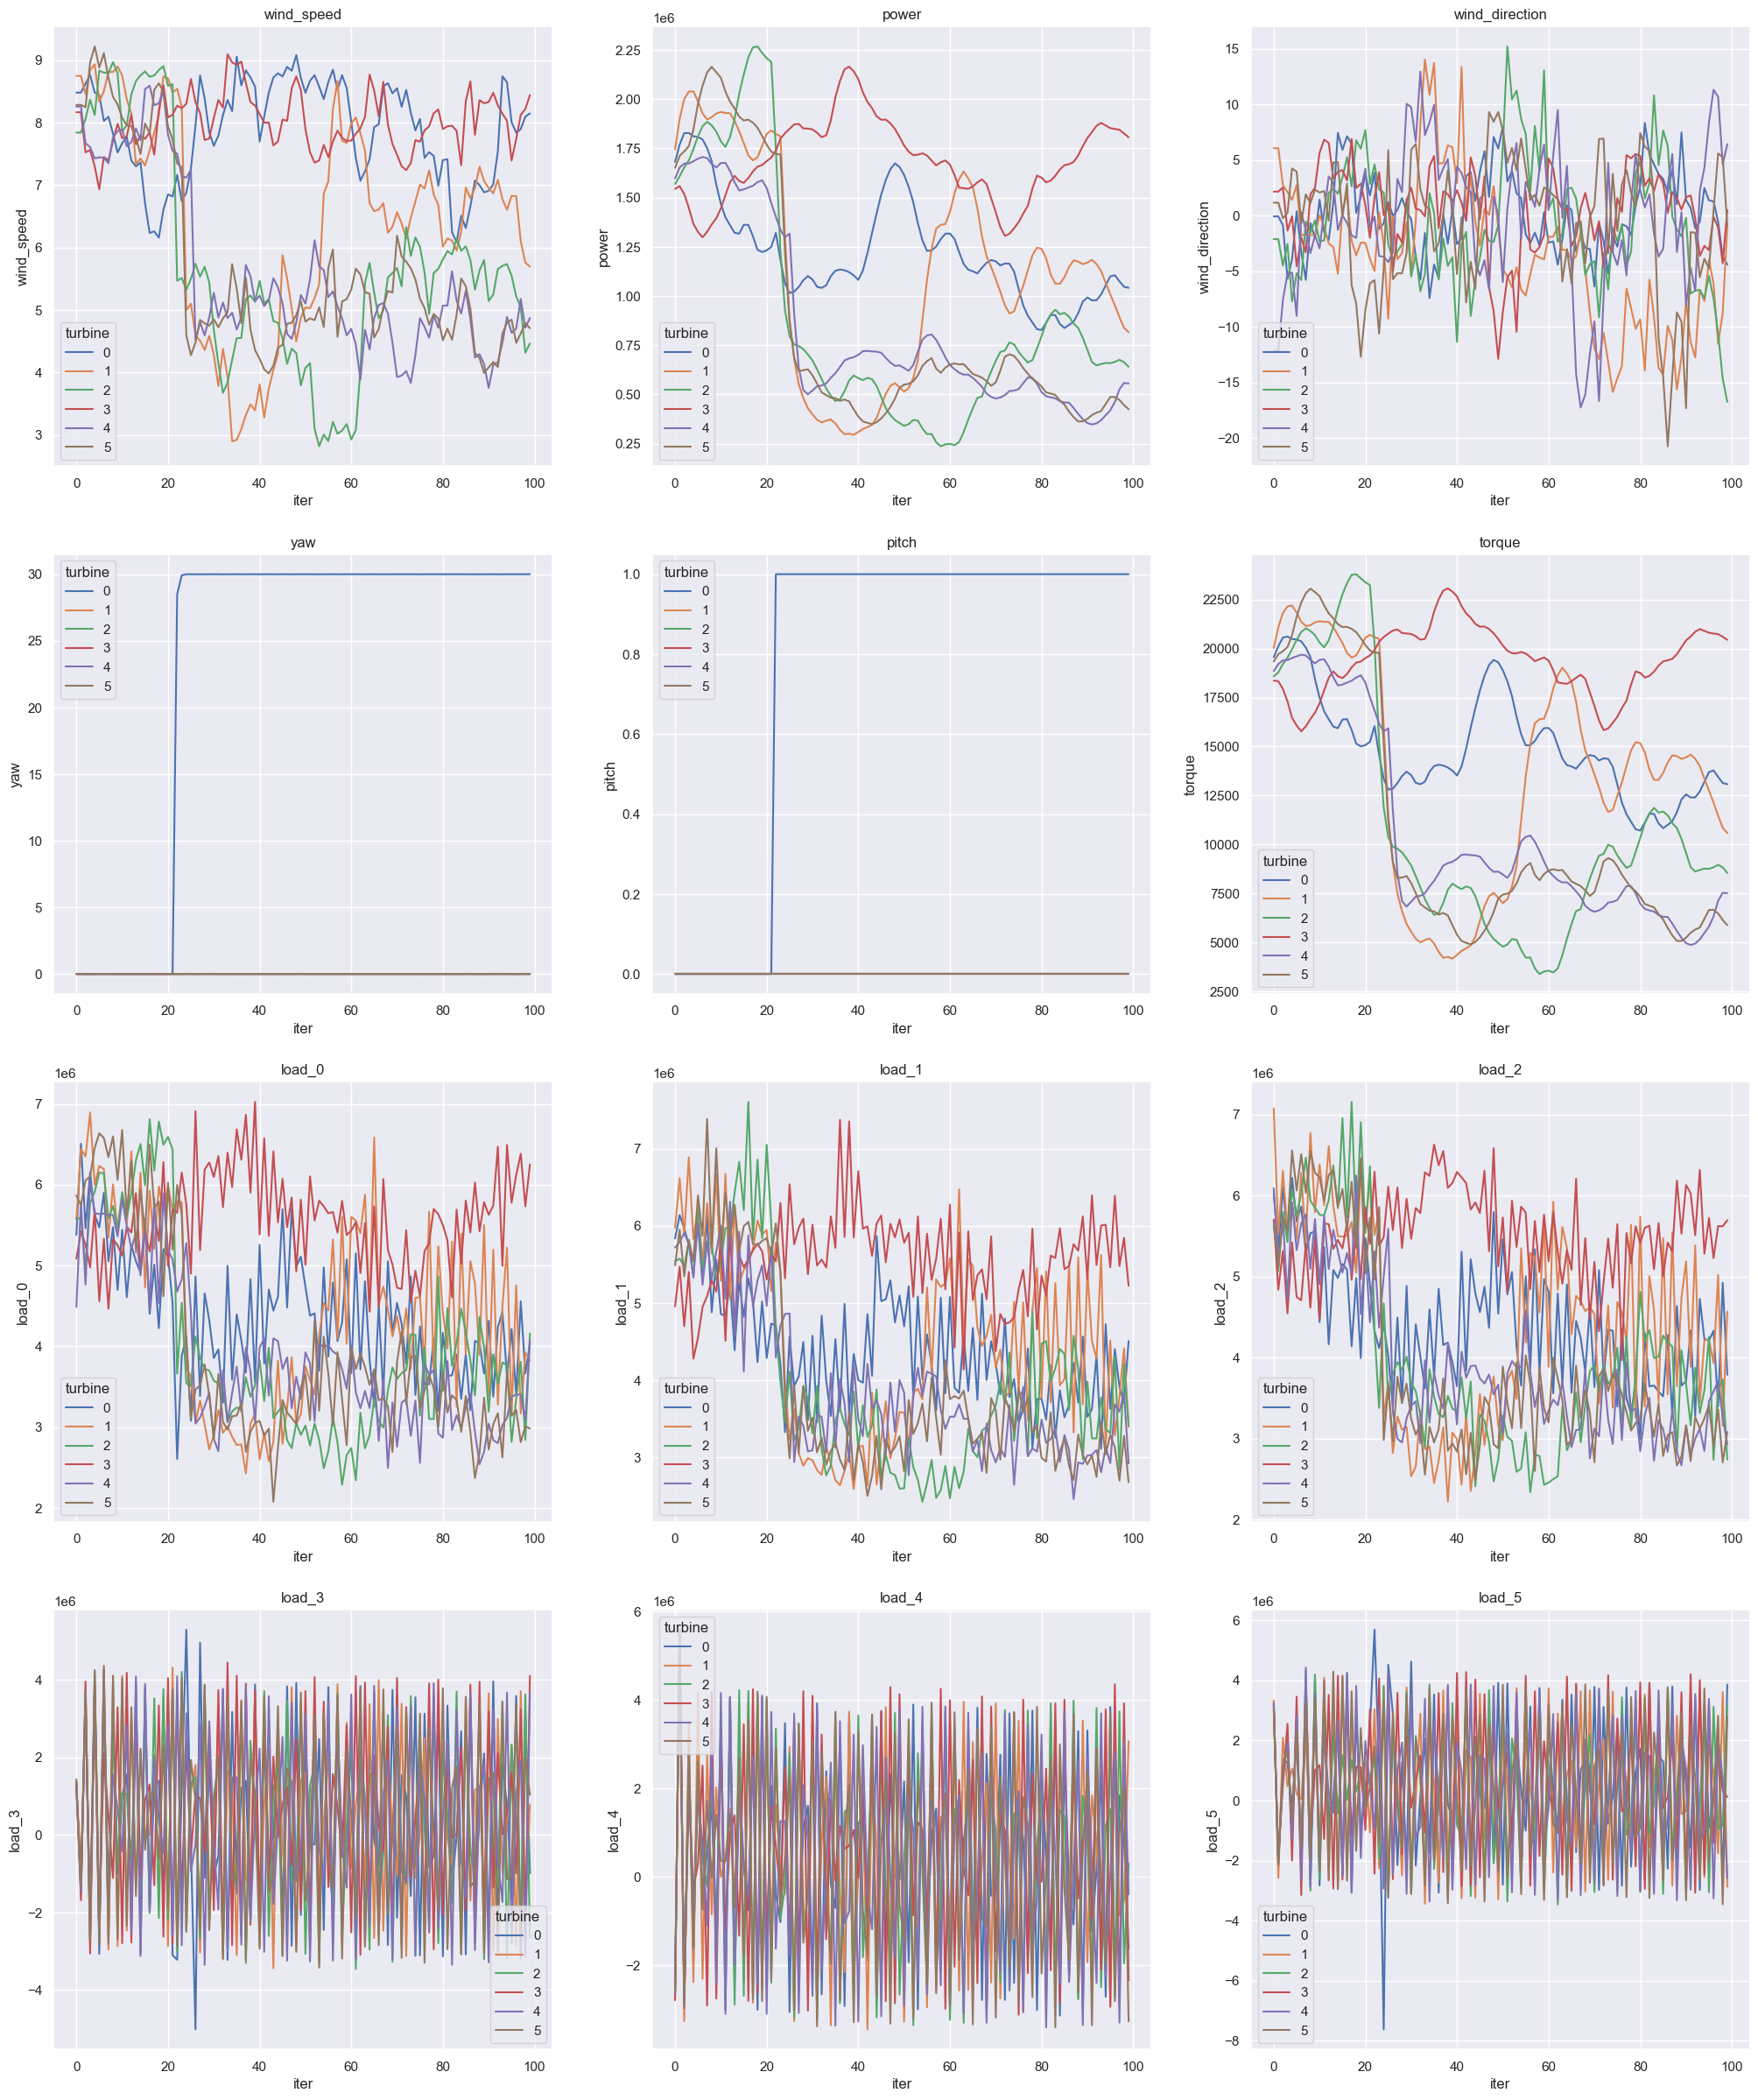

In [17]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(25,30))
for axitem, name in zip(ax.flatten(), df.columns):
    sns.lineplot(df, x="iter", y=name, hue="turbine", ax=axitem, palette="deep")
    axitem.set_title(name)